In [47]:
import os
import sys
import subprocess

REPETITIONS = 3
ARGS = ['images/video_cropped.mp4', 'images/video_cropped_edge.mp4', '3', '6', '0.5', '-1']
bins = ['dog_parallel', 'dog_gpu', 'dog_optimized', 'dog']


print("Usage: python stats.py <repetitions> <input> <output> <sigma1> <sigma2> <threshold> <max_threads> <bin1> <bin2> ...")


Usage: python stats.py <repetitions> <input> <output> <sigma1> <sigma2> <threshold> <max_threads> <bin1> <bin2> ...


In [51]:

def get_stats(bin_path, threads = -1):
    # get the output of the executable
    try:
        # with args ARGS
        script_dir = '/home/casta/CE_edge/CA_Project'
        bin_path = os.path.join(script_dir, bin_path)
        ARGS[0] = os.path.join(script_dir, ARGS[0])
        ARGS[1] = os.path.join(script_dir, ARGS[1])
        ARGS[-1] = str(threads)
# Connect via SSH and execute the script
        ssh_command = f"ssh casta@10.2.85.238 '{bin_path} {' '.join(ARGS)}'"
        try:
            # print(f"Executing {ssh_command}")
            output = subprocess.check_output(ssh_command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            print(f"Error executing {bin_path} via SSH: {e.output.decode()}")
            return None, None, None, None, None
    except subprocess.CalledProcessError as e:
        print(f"Error executing {bin_path}: {e.output.decode()}")
        return None, None, None, None, None
    
    # decode the output
    output = output.decode()
    # parse the output
    lines = output.split('\n')

    cumulative_time = lines[-2].split('\t')

    return cumulative_time



In [7]:
get_stats('dog_gpu')

['0.114111', '0.027700', '0.289003', '0.164072', '0.594886']

In [38]:
# stats for all scripts
results = {}

for bin_path in bins:
    print(f"Running {bin_path}...")
    stat_sums = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}
    stat_squares = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}

    for i in range(REPETITIONS):
        read, grayscale, dog, writer, total = get_stats(bin_path)
        if total:
            stat_sums['read'] += float(read)
            stat_sums['grayscale'] += float(grayscale)
            stat_sums['dog'] += float(dog)
            stat_sums['writer'] += float(writer)
            stat_sums['total'] += float(total)

            stat_squares['read'] += float(read) ** 2
            stat_squares['grayscale'] += float(grayscale) ** 2
            stat_squares['dog'] += float(dog) ** 2
            stat_squares['writer'] += float(writer) ** 2
            stat_squares['total'] += float(total) ** 2

            print(f"Iteration {i + 1} for {bin_path}: read: {read}, grayscale: {grayscale}, dog: {dog}, writer: {writer}, total: {total}")

    variances = {
        stat: (stat_squares[stat] / REPETITIONS) - (stat_sums[stat] / REPETITIONS) ** 2
        for stat in stat_sums
    }
    std_deviation = {
        stat: variances[stat] ** 0.5
        for stat in variances
    }
    means = {
        stat: stat_sums[stat] / REPETITIONS
        for stat in stat_sums
    }

    results[bin_path] = {
        'means': means,
        'variances': variances,
        'std_deviation': std_deviation
    }
    
    print(f"Results for {bin_path}:")
    for stat in means:
        print(f"  {stat}: {means[stat]} ± {std_deviation[stat]} (variance: {variances[stat]})")




Running dog_parallel...
Iteration 1 for dog_parallel: read: 0.124685, grayscale: 0.031069, dog: 8.652172, writer: 0.187901, total: 8.995827
Iteration 2 for dog_parallel: read: 0.114000, grayscale: 0.027258, dog: 7.218025, writer: 0.169656, total: 7.528939
Iteration 3 for dog_parallel: read: 0.123850, grayscale: 0.026713, dog: 7.100504, writer: 0.170432, total: 7.421499
Results for dog_parallel:
  read: 0.120845 ± 0.004852135268793329 (variance: 2.3543216666668115e-05)
  grayscale: 0.02834666666666667 ± 0.0019377960562338122 (variance: 3.7550535555553157e-06)
  dog: 7.656900333333334 ± 0.705396845382001 (variance: 0.49758470947487865)
  writer: 0.17599633333333334 ± 0.008423829704409316 (variance: 7.096090688888876e-05)
  total: 7.9820883333333335 ± 0.7181621922756817 (variance: 0.5157569344142132)
Running dog_gpu...
Iteration 1 for dog_gpu: read: 0.132556, grayscale: 0.029159, dog: 0.135195, writer: 0.173478, total: 0.470388
Iteration 2 for dog_gpu: read: 0.129773, grayscale: 0.026230,

In [13]:
results

{'dog_gpu': {'means': {'read': 0.1292688,
   'grayscale': 0.027636000000000004,
   'dog': 0.13513979999999998,
   'writer': 0.1756924,
   'total': 0.4677372},
  'variances': {'read': 1.894527360001702e-06,
   'grayscale': 4.3475599999969264e-07,
   'dog': 1.0752936000640867e-07,
   'writer': 1.2062146639998939e-05,
   'total': 1.0431706959995735e-05},
  'std_deviation': {'read': 0.0013764183085100627,
   'grayscale': 0.0006593602960443498,
   'dog': 0.00032791669674844045,
   'writer': 0.0034730601261710025,
   'total': 0.0032298153136047477}},
 'dog_parallel': {'means': {'read': 0.061957200000000004,
   'grayscale': 0.0119922,
   'dog': 14.551837999999998,
   'writer': 0.1522136,
   'total': 14.778000800000001},
  'variances': {'read': 0.00576701761536,
   'grayscale': 0.00021581125936000003,
   'dog': 317.6347643042765,
   'writer': 0.03475354503304001,
   'total': 327.58458503011644},
  'std_deviation': {'read': 0.07594088237148684,
   'grayscale': 0.014690515966432222,
   'dog': 17

{'read': [0.111696, 0.10921633333333332, 0.120845, 0.12928933333333334], 'grayscale': [0.028627, 0.028721333333333335, 0.02834666666666667, 0.027296333333333336], 'dog': [187.89527066666665, 22.765707000000003, 7.656900333333334, 0.13482166666666665], 'writer': [0.15730433333333335, 0.15299833333333332, 0.17599633333333334, 0.17332999999999998]}
{'read': [0.003773499525197436, 0.0021143084501143695, 0.004852135268793329, 0.0028850213555915794], 'grayscale': [0.0009984377797338812, 0.0005461631827779465, 0.0019377960562338122, 0.0013217085743670483], 'dog': [0.30043677732031127, 0.04487855579792989, 0.705396845382001, 0.0002645969681608471], 'writer': [0.0003357820059943678, 0.0003376638696870571, 0.008423829704409316, 0.00012423633392162837]}


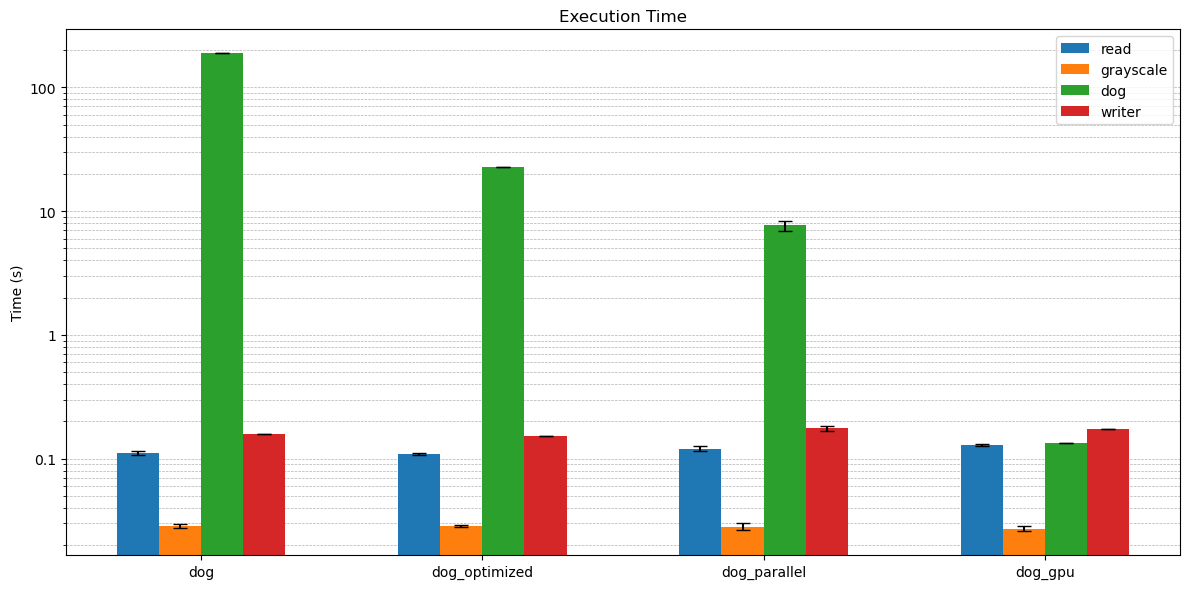

Plot exported as execution_time_plot.pdf


In [42]:
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.pyplot as plt

# Extract data for plotting
#bins = list(results.keys())
categories = ['read', 'grayscale', 'dog', 'writer', 'total'][:-1]  # Exclude 'total' for individual bar plots

# Reorder bins for plotting
bins = ['dog', 'dog_optimized', 'dog_parallel', 'dog_gpu']

# Prepare data for means and confidence intervals
means = {category: [results[bin]['means'][category] for bin in bins] for category in categories}
std_devs = {category: [results[bin]['std_deviation'][category] for bin in bins] for category in categories}

print(means)
print(std_devs)

# Plotting
x = np.arange(len(bins))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each category
for i, category in enumerate(categories):
    ax.bar(x + i * width, means[category], width, label=category, yerr=std_devs[category], capsize=5)

# Add labels, title, and legend
#ax.set_xlabel('Bins')
ax.set_ylabel('Time (s)')
ax.set_title('Execution Time')
ax.set_xticks(x + width * (len(categories) - 1) / 2)
ax.set_xticklabels(bins)
ax.set_yscale('log')
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:g}'))

ax.legend()

# Show plot
plt.tight_layout()
plt.show()

# Export the plot as a PDF
with PdfPages('/tmp/execution_time_plot.pdf') as pdf:
    pdf.savefig(fig)
    print("Plot exported as execution_time_plot.pdf")



In [52]:
# stats for dog_parallel

results_parallel = {}

bin_path = 'dog_parallel'
for threads in range(1, 20):
    print(f"Running {bin_path}...")
    stat_sums = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}
    stat_squares = {'read': 0, 'grayscale': 0, 'dog': 0, 'writer': 0, 'total': 0}

    for i in range(REPETITIONS):
        read, grayscale, dog, writer, total = get_stats(bin_path, threads)
        if total:
            stat_sums['read'] += float(read)
            stat_sums['grayscale'] += float(grayscale)
            stat_sums['dog'] += float(dog)
            stat_sums['writer'] += float(writer)
            stat_sums['total'] += float(total)

            stat_squares['read'] += float(read) ** 2
            stat_squares['grayscale'] += float(grayscale) ** 2
            stat_squares['dog'] += float(dog) ** 2
            stat_squares['writer'] += float(writer) ** 2
            stat_squares['total'] += float(total) ** 2

            print(f"Iteration {i + 1} for {bin_path}, threads {threads}: read: {read}, grayscale: {grayscale}, dog: {dog}, writer: {writer}, total: {total}")

    variances = {
        stat: (stat_squares[stat] / REPETITIONS) - (stat_sums[stat] / REPETITIONS) ** 2
        for stat in stat_sums
    }
    std_deviation = {
        stat: variances[stat] ** 0.5
        for stat in variances
    }
    means = {
        stat: stat_sums[stat] / REPETITIONS
        for stat in stat_sums
    }

    results_parallel[threads] = {
        'means': means,
        'variances': variances,
        'std_deviation': std_deviation
    }
    
    print(f"Results for {bin_path}:")
    for stat in means:
        print(f"  {stat}: {means[stat]} ± {std_deviation[stat]} (variance: {variances[stat]})")


Running dog_parallel...
Iteration 1 for dog_parallel, threads 1: read: 0.150536, grayscale: 0.030389, dog: 26.756231, writer: 0.380809, total: 27.317965
Iteration 2 for dog_parallel, threads 1: read: 0.148910, grayscale: 0.031000, dog: 26.741940, writer: 0.375387, total: 27.297238
Iteration 3 for dog_parallel, threads 1: read: 0.147282, grayscale: 0.031603, dog: 26.817681, writer: 0.374300, total: 27.370866
Results for dog_parallel:
  read: 0.14890933333333334 ± 0.0013284400208093596 (variance: 1.7647528888879715e-06)
  grayscale: 0.03099733333333333 ± 0.0004956170116353159 (variance: 2.4563622222232087e-07)
  dog: 26.77195066666667 ± 0.03285833947964092 (variance: 0.0010796704733593288)
  writer: 0.37683200000000006 ± 0.0028469620065376088 (variance: 8.105192666668648e-06)
  total: 27.328689666666666 ± 0.031000370453054968 (variance: 0.0009610229682266436)
Running dog_parallel...
Iteration 1 for dog_parallel, threads 2: read: 0.149014, grayscale: 0.031112, dog: 14.317738, writer: 0.37

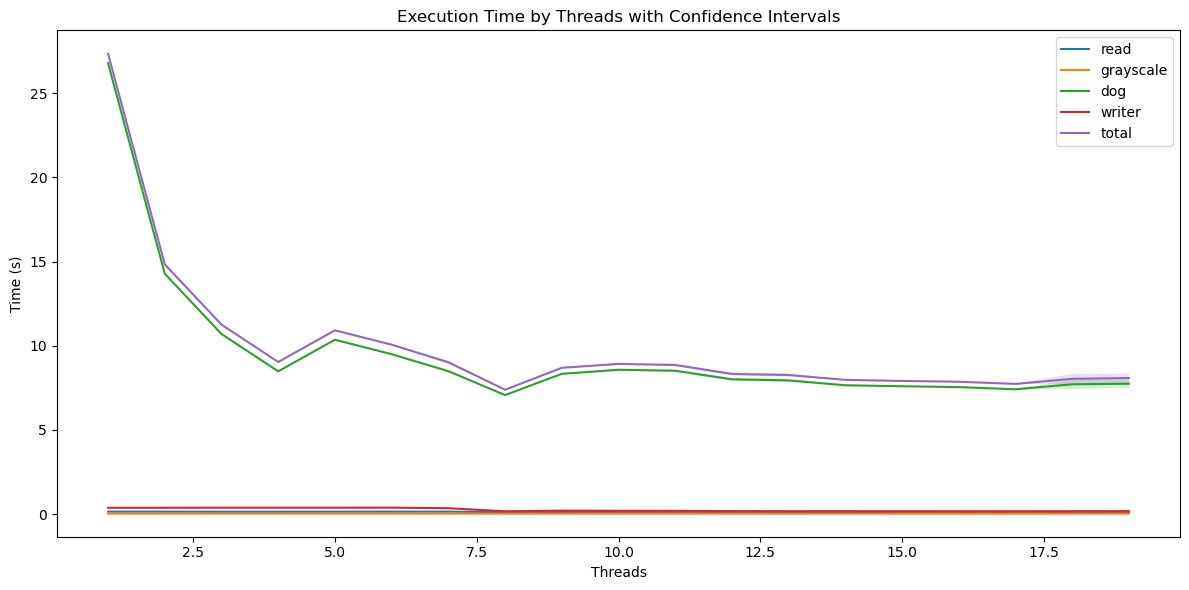

In [55]:
# Extract data for plotting
threads = list(results_parallel.keys())
categories = ['read', 'grayscale', 'dog', 'writer', 'total']

# Prepare data for means and confidence intervals
means_parallel = {category: [results_parallel[t]['means'][category] for t in threads] for category in categories}
std_devs_parallel = {category: [results_parallel[t]['std_deviation'][category] for t in threads] for category in categories}

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

for category in categories:
    mean_values = means_parallel[category]
    std_values = std_devs_parallel[category]
    ax.plot(threads, mean_values, label=category)
    ax.fill_between(threads, 
                    [m - s for m, s in zip(mean_values, std_values)], 
                    [m + s for m, s in zip(mean_values, std_values)], 
                    alpha=0.2)

# Add labels, title, and legend
ax.set_xlabel('Threads')
ax.set_ylabel('Time (s)')
ax.set_title('Execution Time by Threads with Confidence Intervals')
#ax.set_yscale('log')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()